In [1]:
from collections import OrderedDict
import gc
import pathlib
from pprint import pprint
import random
from typing import Dict, List, Tuple, Union

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder


gc.enable()

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
competition_dir = pathlib.Path('/kaggle/input/home-credit-credit-risk-model-stability')
feature_dtype_dir = pathlib.Path('/kaggle/input/0-home-credit-eda')

In [3]:
bool_features = pl.read_csv(feature_dtype_dir.joinpath('bool_features.csv'))
float64_features = pl.read_csv(feature_dtype_dir.joinpath('float64_features.csv'))
string_features = pl.read_csv(feature_dtype_dir.joinpath('string_features.csv'))

display(bool_features)
display(float64_features)
display(string_features)

cast_features = OrderedDict()
cast_features['case_id'] = pl.Int32

for k in bool_features.select('Variable').to_series():
    cast_features[k] = pl.Boolean

for k in float64_features.select('Variable').to_series():
    cast_features[k] = pl.Float32

for k in string_features.select('Variable').to_series():
    cast_features[k] = pl.String

print(f'the number of features: {len(cast_features.keys())}')
pprint(cast_features)

Variable,Description,train_num_unique_values,train_unique_types,train_num_nan,train_files,train_num_unique_types,test_num_unique_values,test_unique_types,test_num_nan,test_files,test_num_unique_types
str,str,i64,str,i64,str,i64,i64,str,i64,str,i64
"""remitter_829L""","""Flag indicatin…",2,"""bool""",2168942,"""['train_person…",1,2,"""bool""",6,"""['test_person_…",1
"""contaddr_match…","""Indicates whet…",2,"""bool""",1447773,"""['train_person…",1,2,"""bool""",5,"""['test_person_…",1
"""isbidproduct_1…","""Flag indicatin…",2,"""bool""",0,"""['train_static…",1,2,"""bool""",0,"""['train_static…",1
"""isdebitcard_72…","""Flag indicatin…",2,"""bool""",1334357,"""['train_static…",1,2,"""bool""",2,"""['train_static…",1
"""contaddr_smemp…","""Indicates whet…",3,"""bool""",1447773,"""['train_person…",1,2,"""bool""",5,"""['test_person_…",1
"""equalitydataag…","""Flag indicatin…",3,"""bool""",1448632,"""['train_static…",1,2,"""bool""",26,"""['train_static…",1
"""opencred_647L""","""Number of acti…",3,"""bool""",305137,"""['train_static…",1,2,"""bool""",0,"""['train_static…",1
"""isreference_38…","""Flag indicatin…",3,"""bool""",2949075,"""['train_person…",1,3,"""bool""",8,"""['test_person_…",1
"""isdebitcard_52…","""Previous appli…",3,"""bool""",6062966,"""['train_applpr…",1,3,"""bool""",21,"""['test_applpre…",1


Variable,Description,train_num_unique_values,train_unique_types,train_num_nan,train_files,train_num_unique_types,test_num_unique_values,test_unique_types,test_num_nan,test_files,test_num_unique_types
str,str,i64,str,i64,str,i64,i64,str,i64,str,i64
"""deferredmnthsn…","""Number of defe…",1,"""float64""",0,"""['train_static…",1,4,"""float64""",26,"""['train_static…",1
"""formonth_118L""","""Number of reje…",2,"""float64""",1463962,"""['train_static…",1,1,"""float64""",10,"""['test_static_…",1
"""forweek_601L""","""Number of reje…",2,"""float64""",1463962,"""['train_static…",1,1,"""float64""",10,"""['test_static_…",1
"""forquarter_462…","""Number of cred…",2,"""float64""",1463962,"""['train_static…",1,1,"""float64""",10,"""['test_static_…",1
"""residualamount…","""Residual amoun…",3,"""float64""",69666,"""['train_credit…",1,2,"""float64""",8,"""['test_credit_…",1
"""mastercontrele…","""Flag indicatin…",3,"""float64""",306019,"""['train_static…",1,1,"""float64""",0,"""['train_static…",1
"""mastercontrexi…","""Flag indicatin…",3,"""float64""",306019,"""['train_static…",1,1,"""float64""",0,"""['train_static…",1
"""commnoinclast6…","""Number of comm…",3,"""float64""",343375,"""['train_static…",1,1,"""float64""",0,"""['train_static…",1
"""for3years_128L…","""Number of reje…",3,"""float64""",1463962,"""['train_static…",1,1,"""float64""",10,"""['test_static_…",1


Variable,Description,train_num_unique_values,train_unique_types,train_num_nan,train_files,train_num_unique_types,test_num_unique_values,test_unique_types,test_num_nan,test_files,test_num_unique_types
str,str,i64,str,i64,str,i64,i64,str,i64,str,i64
"""paytype_783L""","""Type of paymen…",2,"""str""",58575,"""['train_static…",1,2,"""str""",22,"""['train_static…",1
"""role_993L""","""Person's role.…",2,"""str""",2949075,"""['train_person…",1,2,"""str""",8,"""['test_person_…",1
"""typesuite_864L…","""Persons accomp…",2,"""str""",1121505,"""['train_static…",1,2,"""str""",25,"""['train_static…",1
"""bankacctype_71…","""Type of applic…",2,"""str""",1109629,"""['train_static…",1,2,"""str""",17,"""['train_static…",1
"""paytype1st_925…","""Type of first …",2,"""str""",58575,"""['train_static…",1,2,"""str""",22,"""['train_static…",1
"""description_50…","""Categorization…",2,"""str""",0,"""['train_static…",1,1,"""str""",0,"""['test_static_…",1
"""language1_981M…","""The primary la…",3,"""str""",0,"""['train_person…",1,2,"""str""",0,"""['test_person_…",1
"""cardtype_51L""","""Type of credit…",3,"""str""",1334968,"""['train_static…",1,2,"""str""",28,"""['train_static…",1
"""sex_738L""","""Gender of the …",3,"""str""",1447332,"""['train_person…",1,3,"""str""",4,"""['test_person_…",1


the number of features: 465
OrderedDict([('case_id', Int32),
             ('remitter_829L', Boolean),
             ('contaddr_matchlist_1032L', Boolean),
             ('isbidproduct_1095L', Boolean),
             ('isdebitcard_729L', Boolean),
             ('contaddr_smempladdr_334L', Boolean),
             ('equalitydataagreement_891L', Boolean),
             ('opencred_647L', Boolean),
             ('isreference_387L', Boolean),
             ('isdebitcard_527L', Boolean),
             ('isbidproductrequest_292L', Boolean),
             ('safeguarantyflag_411L', Boolean),
             ('isbidproduct_390L', Boolean),
             ('equalityempfrom_62L', Boolean),
             ('deferredmnthsnum_166L', Float32),
             ('formonth_118L', Float32),
             ('forweek_601L', Float32),
             ('forquarter_462L', Float32),
             ('residualamount_1093A', Float32),
             ('mastercontrelectronic_519L', Float32),
             ('mastercontrexist_109L', Float32),
    

In [4]:
train_depth_files = OrderedDict()

train_depth_files['train_static_0'] = ['train_static_0_0.parquet',
                                        'train_static_0_1.parquet']
train_depth_files['train_static_cb_0'] = ['train_static_cb_0.parquet']
train_depth_files['train_applprev_1'] = ['train_applprev_1_0.parquet',
                                          'train_applprev_1_1.parquet']
train_depth_files['train_other_1'] = ['train_other_1.parquet']
train_depth_files['train_tax_registry_a_1'] = ['train_tax_registry_a_1.parquet']
train_depth_files['train_tax_registry_b_1'] = ['train_tax_registry_b_1.parquet']
train_depth_files['train_tax_registry_c_1'] = ['train_tax_registry_c_1.parquet']
train_depth_files['train_credit_bureau_a_1'] = ['train_credit_bureau_a_1_0.parquet',
                                                'train_credit_bureau_a_1_1.parquet',
                                                'train_credit_bureau_a_1_2.parquet',
                                                'train_credit_bureau_a_1_3.parquet']
train_depth_files['train_credit_bureau_b_1'] = ['train_credit_bureau_b_1.parquet']
train_depth_files['train_deposit_1'] = ['train_deposit_1.parquet']
train_depth_files['train_person_1'] = ['train_person_1.parquet']
train_depth_files['train_debitcard_1'] = ['train_debitcard_1.parquet']

train_depth_files['train_applprev_2'] = ['train_applprev_2.parquet']
train_depth_files['train_person_2'] = ['train_person_2.parquet']
train_depth_files['train_credit_bureau_a_2'] = ['train_credit_bureau_a_2_0.parquet',
                                                'train_credit_bureau_a_2_1.parquet',
                                                'train_credit_bureau_a_2_2.parquet',
                                                'train_credit_bureau_a_2_3.parquet',
                                                'train_credit_bureau_a_2_4.parquet',
                                                'train_credit_bureau_a_2_5.parquet',
                                                'train_credit_bureau_a_2_6.parquet',
                                                'train_credit_bureau_a_2_7.parquet',
                                                'train_credit_bureau_a_2_8.parquet',
                                                'train_credit_bureau_a_2_9.parquet',
                                                'train_credit_bureau_a_2_10.parquet']
train_depth_files['train_credit_bureau_b_2'] = ['train_credit_bureau_b_2.parquet']

print(f'the number of train files: {sum(len(v1) for v1 in train_depth_files.values())}')

train_depth_paths = OrderedDict()
for k, path_list in train_depth_files.items():
    train_depth_paths[k] = list(
        map(lambda p: competition_dir.joinpath('parquet_files/train/'+p), path_list)
    )
    
print(f'number of train paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

the number of train files: 31
number of train paths: 31


In [5]:
def merge_dataset(
        base_data: pl.DataFrame,
        depth_paths: Dict[str, List[pathlib.Path]],
        cast_features: Dict[str, object],
        depth: str,
    ) -> pd.DataFrame:
    
    assert depth in ['0', '1', '2', '012']
    
    for i, (k, path_list) in enumerate(depth_paths.items()):
        
        if depth == '012':
            pass
        elif depth != k[-1]:
            continue
            
        print(f'loading `{k}`')
        depth_data = []
        for p in path_list:
            sub_data = pl.read_parquet(p)
            sub_data = sub_data.cast(
                {k: v for k, v in cast_features.items() if k in sub_data.columns}
            )
            if k[-1] == '1':
                sub_data = sub_data.drop('num_group1')
            elif k[-1] == '2':
                sub_data = sub_data.drop(['num_group1', 'num_group2'])
            if k[-1] == '1' or k[-1] == '2':
                sub_data = sub_data.group_by('case_id').sum().sort('case_id')
                
            depth_data.append(sub_data)
            
            print(f'\t{sub_data.shape}')
            
            del sub_data
            gc.collect()
        
        depth_data = pl.concat(depth_data, how='vertical_relaxed')
        base_data = base_data.join(depth_data, how='left', on='case_id', suffix=f'_{i}')
        
        del depth_data
        gc.collect()
    
    return base_data.to_pandas()

In [6]:
train_base_data = pl.read_parquet(competition_dir.joinpath('parquet_files/train/train_base.parquet'))
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int32,
        'date_decision': pl.String,
        'MONTH': pl.Int32,
        'WEEK_NUM': pl.Int16,
        'target': pl.Int8,
    }
)
display(train_base_data)

case_id,date_decision,MONTH,WEEK_NUM,target
i32,str,i32,i16,i8
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
5,"""2019-01-02""",201901,0,0
6,"""2019-01-03""",201901,0,0
7,"""2019-01-03""",201901,0,0
8,"""2019-01-03""",201901,0,0


In [7]:
%%time


depth_data = merge_dataset(train_base_data, train_depth_paths, cast_features, '012')
display(depth_data)

not_T_L_columns = [col for col in depth_data.columns if col[-1] not in ['T', 'L']]
depth_data = depth_data[not_T_L_columns]
display(depth_data)

loading `train_static_0`
	(1003757, 168)
	(522902, 168)
loading `train_static_cb_0`
	(1500476, 53)
loading `train_applprev_1`
	(782997, 40)
	(438525, 40)
loading `train_other_1`
	(51109, 6)
loading `train_tax_registry_a_1`
	(457934, 4)
loading `train_tax_registry_b_1`
	(150732, 4)
loading `train_tax_registry_c_1`
	(482265, 4)
loading `train_credit_bureau_a_1`
	(335275, 78)
	(549263, 78)
	(325127, 78)
	(176608, 78)
loading `train_credit_bureau_b_1`
	(36500, 44)
loading `train_deposit_1`
	(105111, 4)
loading `train_person_1`
	(1526659, 36)
loading `train_debitcard_1`
	(111772, 5)
loading `train_applprev_2`
	(1221522, 4)
loading `train_person_2`
	(1435105, 9)
loading `train_credit_bureau_a_2`
	(98303, 17)
	(118481, 17)
	(156749, 17)
	(190486, 17)
	(190313, 17)
	(231250, 17)
	(150426, 17)
	(45056, 17)
	(77457, 17)
	(103033, 17)
	(23734, 17)
loading `train_credit_bureau_b_2`
	(36447, 4)


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,1560.0,0.00000,9269.240234,72687.0,483512.0,None,None,None,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,624.0,0.00000,0.000000,48470.0,193712.0,None,None,None,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,468.0,4884.29834,0.000000,121157.0,145146.0,None,None,None,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,2262.0,0.00000,25154.000000,48470.0,700949.0,None,None,None,NaN,NaN


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avgdbddpdlast24m_3658932P,...,collaterals_typeofguarante_669M,pmts_dpd_1073P,pmts_dpd_303P,pmts_overdue_1140A,pmts_overdue_1152A,subjectroles_name_541M,subjectroles_name_838M,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,-23.0,...,None,0.0,105.0,0.00000,9269.240234,None,None,None,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,-18.0,...,None,0.0,0.0,0.00000,0.000000,None,None,None,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,-12.0,...,None,16.0,0.0,4884.29834,0.000000,None,None,None,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,-33.0,...,None,0.0,73.0,0.00000,25154.000000,None,None,None,NaN,NaN


CPU times: user 3min 52s, sys: 1min 47s, total: 5min 39s
Wall time: 1min 54s


In [8]:
class CFG:
    def __init__(
            self,
            outputs_dir: pathlib.Path,
            n_splits: int = 5,
            lr: float = 0.1,
            max_depth: int = -1,
            num_leaves: int = 31,
            min_data_in_leaf: int = 20,
            bagging_fraction: float = 1.0,
            feature_fraction_bynode: float = 1.0,
            seed: int = 42,
            device: str = 'cpu',
            debag: bool = False,
        ):
        
        self.outputs_dir = outputs_dir
        self.n_splits = n_splits
        self.lr = lr
        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.min_data_in_leaf = min_data_in_leaf
        self.bagging_fraction = bagging_fraction
        self.feature_fraction_bynode = feature_fraction_bynode
        self.seed = seed
        self.device = device
        self.debag = debag
        
    def seed_everything(self):
        random.seed(self.seed)
        np.random.seed(self.seed)

In [9]:
def train(config, Xy):
    
    kfold = StratifiedGroupKFold(
        n_splits=config.n_splits,
        shuffle=True,
        random_state=config.seed,
    )
    
    y = Xy['target'].copy()
    groups = Xy['WEEK_NUM'].copy()
    oof = Xy[['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']].copy()
    oof_probas = np.zeros(len(oof))
    X = Xy[[col for col in Xy.columns if col not in ['case_id', 'target']]].copy()
    not_object_columns = (X.dtypes.loc[X.dtypes!=object]).index
    print(not_object_columns)
    print(len(not_object_columns))
    X = X[not_object_columns]
    display(X)
    display(oof)
    
    np.save(config.outputs_dir.joinpath('training_features.npy'), X.columns.to_numpy())
    
    del Xy
    gc.collect()
    
    model_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['average_precision', 'auc'],
        'learning_rate': config.lr,
        'seed': config.seed,
        'max_depth': config.max_depth,
        'num_leaves': config.num_leaves,
        'min_data_in_leaf': config.min_data_in_leaf,
        'bagging_fraction': config.bagging_fraction,
        'feature_fraction_bynode': config.feature_fraction_bynode,
        'device': config.device,
    }
    
    for k, (train_indices, valid_indices) in enumerate(kfold.split(X=X, y=y, groups=groups)):
        print(f'fold: {k+1}')
        
        train_X = X.iloc[train_indices]
        valid_X = X.iloc[valid_indices]
        
        train_y = y.iloc[train_indices]
        valid_y = y.iloc[valid_indices]
        
        train_dataset = lgb.Dataset(data=train_X, label=train_y)
        valid_dataset = lgb.Dataset(data=valid_X, label=valid_y, reference=train_dataset)
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, first_metric_only=True, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=1000,
        )
        model.save_model(
            config.outputs_dir.joinpath(f'lgb_fold{k+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        oof_probas[valid_indices] = model.predict(valid_X, num_iteration=model.best_iteration)
    oof.loc[:, 'probability'] = oof_probas
    
    del oof_probas
    gc.collect()
    
    return oof

In [10]:
%%time


config = CFG(
    outputs_dir=pathlib.Path('.'),
    n_splits=5,
    lr=1e-02,
    max_depth=10,
    min_data_in_leaf=100,
    bagging_fraction=0.8,
    feature_fraction_bynode=0.6,
    seed=42,
    device='gpu',
    debag=False,
)
config.seed_everything()

if config.debag:
    oof = train(config, depth_data.iloc[:10000])
else:
    oof = train(config, depth_data)

Index(['MONTH', 'WEEK_NUM', 'actualdpdtolerance_344P',
       'amtinstpaidbefduel24m_4187115A', 'annuity_780A',
       'annuitynextmonth_57A', 'avgdbddpdlast24m_3658932P',
       'avgdbddpdlast3m_4187120P', 'avgdbdtollast24m_4525197P',
       'avgdpdtolclosure24_3658938P',
       ...
       'mainoccupationinc_384A', 'last180dayaveragebalance_704A',
       'last180dayturnover_1134A', 'last30dayturnover_651A', 'pmts_dpd_1073P',
       'pmts_dpd_303P', 'pmts_overdue_1140A', 'pmts_overdue_1152A',
       'pmts_dpdvalue_108P', 'pmts_pmtsoverdue_635A'],
      dtype='object', length=137)
137


,MONTH,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,...,mainoccupationinc_384A,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,pmts_dpd_1073P,pmts_dpd_303P,pmts_overdue_1140A,pmts_overdue_1152A,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,201901,0,NaN,NaN,1917.599976,0.000000,NaN,NaN,NaN,NaN,...,10800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201901,0,NaN,NaN,3134.000000,0.000000,NaN,NaN,NaN,NaN,...,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201901,0,NaN,NaN,4937.000000,0.000000,NaN,NaN,NaN,NaN,...,14000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201901,0,NaN,NaN,4643.600098,0.000000,NaN,NaN,NaN,NaN,...,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201901,0,NaN,NaN,3390.199951,0.000000,NaN,NaN,NaN,NaN,...,24000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,202010,91,0.0,176561.359375,3675.400146,0.000000,-23.0,-43.0,-23.0,0.0,...,40000.0,NaN,NaN,NaN,0.0,105.0,0.00000,9269.240234,NaN,NaN
1526655,202010,91,0.0,301276.468750,7088.600098,6191.600098,-18.0,-12.0,-18.0,0.0,...,36800.0,NaN,NaN,NaN,0.0,0.0,0.00000,0.000000,NaN,NaN
1526656,202010,91,0.0,14232.400391,7788.800293,0.000000,-12.0,NaN,-16.0,1.0,...,30000.0,NaN,NaN,NaN,16.0,0.0,4884.29834,0.000000,NaN,NaN
1526657,202010,91,0.0,197371.578125,1195.400024,2827.199951,-33.0,-64.0,-34.0,0.0,...,30000.0,0.0,0.0,0.0,0.0,73.0,0.00000,25154.000000,NaN,NaN


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


fold: 1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37982, number of negative: 1164520
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 30167
[LightGBM] [Info] Number of data points in the train set: 1202502, number of used features: 137
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 63 dense feature groups (73.39 MB) transferred to GPU in 0.053177 secs. 1 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031586 -> initscore=-3.422952
[LightGBM] [Info] Start training from score -3.422952
Training until validation scores don't improve for 100 rounds
[100]	train's average_precision: 0.125055	train's auc: 0.771639	valid's average_precision: 0.126204	valid's auc: 0.778926
[200]	train's average_precision: 0.137758	train's auc: 0.791015	valid's average_precision: 0.13961	valid's auc: 0.797479
[300]	train's average_precision: 0.146397	train's auc: 0.80248	valid's average_precision: 0.147601	valid's auc: 0.80888
[400]	train's average_precision: 0.152733	train's auc: 0.809825	valid's average_precision: 0.152208	v

,case_id,date_decision,MONTH,WEEK_NUM,target,probability
0,0,2019-01-03,201901,0,0,0.046687
1,1,2019-01-03,201901,0,0,0.045727
2,2,2019-01-04,201901,0,0,0.059196
3,3,2019-01-03,201901,0,0,0.064316
4,4,2019-01-04,201901,0,1,0.048953
...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.003568
1526655,2703451,2020-10-05,202010,91,0,0.003750
1526656,2703452,2020-10-05,202010,91,0,0.033734
1526657,2703453,2020-10-05,202010,91,0,0.002513


count    1.526659e+06
mean     3.138732e-02
std      4.215191e-02
min      5.800343e-04
25%      7.433796e-03
50%      1.742151e-02
75%      3.745491e-02
max      8.629176e-01
Name: probability, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


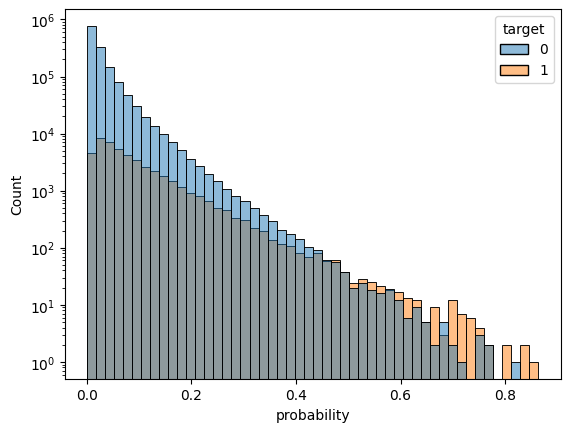

In [11]:
display(oof)
print(oof['probability'].describe())

_, ax = plt.subplots()
sns.histplot(data=oof, x='probability', hue='target', bins=50, ax=ax)
plt.yscale('log')
plt.show()

In [12]:
def plot_gini(y_truth: pd.DataFrame, y_pred: np.ndarray) -> Tuple[pd.DataFrame, float]:
    gini_weeks = []
    
    for week in range(0, 92):
        idx_week = (y_truth['WEEK_NUM'] == week)
        y_pred_week = y_pred[idx_week]
        y_test_week = y_truth[idx_week]
        gini_week = 2 * roc_auc_score(y_test_week['target'], y_pred_week) - 1
        gini_weeks.append(gini_week)

    gini_weeks = np.array(gini_weeks)
    linear_regression = LinearRegression()
    linear_regression.fit(np.arange(0, 92).reshape(-1, 1), gini_weeks)
    a, b = linear_regression.coef_[0], linear_regression.intercept_

    residuals = gini_weeks - linear_regression.predict(np.arange(0, 92).reshape(-1, 1))
    stability = gini_weeks.mean() + 88.0 * np.amin([0, a]) - 0.5 * residuals.std()
    print(stability)

    _, ax = plt.subplots()
    ax.plot(gini_weeks, marker='o', linestyle='', label='Gini coefficient', alpha=0.5)
    ax.plot(
        linear_regression.predict(np.arange(0, 92).reshape(-1, 1)),
        label=f'y = {a:.4f}x + {b:.4f}'
    )
    ax.set(
        xlabel='WEEK_NUM',
        ylabel='Gini coefficient',
        ylim=[0, 1],
        title='stability: {:.4f}'.format(stability)
    )
    ax.legend()
    plt.show()
    
    df_gini_weeks = pd.DataFrame(
        {
            'WEEK_NUM': np.arange(0, 92),
            'Gini': gini_weeks,
        }
    )
    return df_gini_weeks, stability

0.6073506557479237


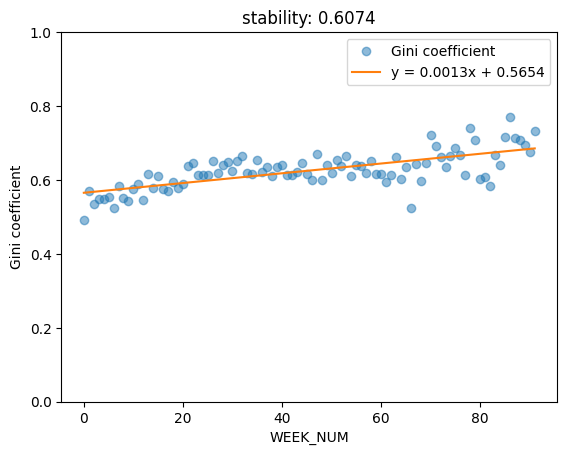

In [13]:
gini_weeks, stability = plot_gini(oof, oof['probability'])